# TorchVision Object Detection Finetuning Tutorial

https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html#torchvision-object-detection-finetuning-tutorial

# 0. 자신의 개발환경이 PyTorch GPU 버전을 사용할 수 있는지 확인해 봅니다.

In [2]:
import torch

In [3]:
torch.__version__

'2.5.1'

In [4]:
torch.cuda.is_available()

True

# 1. 다음 경로에서 PennFudanPed dataset 를 다운로드 받아 자신의 개발환경에 압축을 풉니다.

https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip

# 2. 다음 명령어로 디렉토리의 데이터를 확인해 봅니다.

In [ ]:
!dir PennFudanPed/

# 3. 다운로드 받은 데이터 중 하나의 이미지를 읽어 봅니다. (hint: torchvision.io.read_image)

* 경로: PennFudanPed/PNGImages/FudanPed00001.png

In [1]:
from torchvision.io import read_image

In [6]:
img_path = 'data/PennFudanPed/PNGImages/FudanPed00001.png'
image = read_image(img_path)
type(image), image.shape

(torch.Tensor, torch.Size([3, 536, 559]))

# 4. 읽어 드린 이미지를 화면에 출력해 봅니다. - hint: image.permute(1, 2, 0), plt.imshow

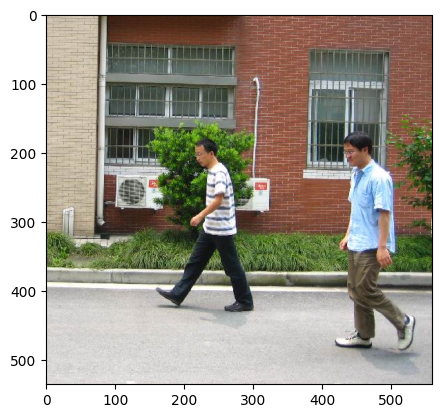

In [9]:
import matplotlib.pyplot as plt

image = image.permute(1, 2, 0)
plt.imshow(image)

# 5. 튜토리얼의 PennFudanDataset class 를 이용하여 dataset 객체를 생성하세요. (hint: 클래스의 생성자를 확인하여 어떤 인자들을 전달해야 하는지 파악합니다.)

* F.get_size 에러 발생 시: F.get_image_size 사용

In [22]:
import os
import torch

from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = read_image(img_path)
        mask = read_image(mask_path)
        # instances are encoded as different colors
        obj_ids = torch.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)

        # split the color-encoded mask into a set
        # of binary masks
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)

        # get bounding box coordinates for each mask
        boxes = masks_to_boxes(masks)

        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Wrap sample and targets into torchvision tv_tensors:
        img = tv_tensors.Image(img)

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_image_size(img))
        # target["masks"] = tv_tensors.Mask(masks)
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [23]:
import torchvision.transforms.v2 as v2

transforms = v2.Compose([
            v2.ToImage(),
            v2.ToDtype(torch.float, scale=True),
            ])

In [24]:
dataset = PennFudanDataset(root='data/PennFudanPed', transforms=transforms)

In [25]:
dataset[0][0].shape, dataset[0][1]['boxes'].shape

c:\DevTool\anaconda3\envs\torch_book\Lib\site-packages\torchvision\transforms\v2\functional\_deprecated.py:20: UserWarning: The function `get_image_size(...)` is deprecated and will be removed in a future release. Instead, please use `get_size(...)` which returns `[h, w]` instead of `[w, h]`.
  warnings.warn(


(torch.Size([3, 536, 559]), torch.Size([2, 4]))

# 6. dataset 으로부터 이미지, bbox, label 을 함께 화면에 표시하세요. (hint: torchvision.utils.draw_bounding_boxes, v2.ToPILImage())

In [27]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
from torchvision.utils import draw_bounding_boxes

image_tensor, target = dataset[0]
boxes = target['boxes']
labels = target['labels']

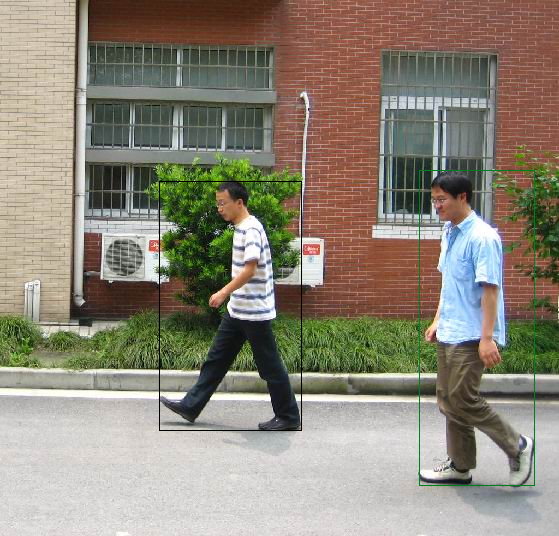

In [29]:
bbox_image = draw_bounding_boxes(image=image_tensor, boxes=boxes) # tensor로 반환

t = v2.ToPILImage() # tensor 데이터를 PILImage로 변환
t(bbox_image)

# 7. PennFudanDataset 객체를 두 개 만들어 dataset_train 와 dataset_test 변수에 저장합니다. 그런 다음 데이터를 읽을 수 있는지 테스트해 봅니다.
# 8. 주어진 코드를 이용하여 train 과 test 로 데이터를 나눕니다. (120개, 50개)

In [30]:
from torchvision import transforms
import utils

image_transforms = {
    'train': transforms.v2.Compose([
        transforms.v2.RandomHorizontalFlip(),
        transforms.v2.ToImage(),
        transforms.v2.ToDtype(torch.float32, scale=True),
    ]),
    'test': transforms.v2.Compose([
        transforms.v2.ToImage(),
        transforms.v2.ToDtype(torch.float32, scale=True),
    ]),
}

# use our dataset and defined transformations
dataset_train = PennFudanDataset('data/PennFudanPed', image_transforms['train'])
dataset_test = PennFudanDataset('data/PennFudanPed', image_transforms['test'])

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset_train = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset_train,
    batch_size=2,
    shuffle=True,
    collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    collate_fn=utils.collate_fn
)

In [33]:
len(dataset_train), len(dataset_test)

(120, 50)

In [31]:
for X, y in dataset_train:
  print(type(X), X.shape)
  print(type(y), y['boxes'], y['labels']) # background and person
  print(y.keys())
  break

<class 'torchvision.tv_tensors._image.Image'> torch.Size([3, 323, 352])
<class 'dict'> BoundingBoxes([[ 64.,  26., 180., 316.]], format=BoundingBoxFormat.XYXY, canvas_size=[352, 323]) tensor([1])
dict_keys(['boxes', 'labels', 'image_id', 'area', 'iscrowd'])


In [32]:
for X, y in dataset_test:
  print(type(X), X.shape)
  print(type(y), y['boxes'], y['labels']) # background and person
  print(y.keys())
  break

<class 'torchvision.tv_tensors._image.Image'> torch.Size([3, 345, 317])
<class 'dict'> BoundingBoxes([[  6.,  15., 148., 302.],
               [185.,  17., 315., 320.]], format=BoundingBoxFormat.XYXY, canvas_size=[317, 345]) tensor([1, 1])
dict_keys(['boxes', 'labels', 'image_id', 'area', 'iscrowd'])


# 9. Faster RCNN 모델을 생성합니다.

https://pytorch.org/vision/main/models/generated/torchvision.models.detection.fasterrcnn_resnet50_fpn_v2.html

* fasterrcnn_resnet50_fpn_v2 도우미 함수를 사용하세요.
* weights 는 FasterRCNN_ResNet50_FPN_V2_Weights 를 사용하세요.



In [34]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_V2_Weights

weights = FasterRCNN_ResNet50_FPN_V2_Weights.COCO_V1
model = fasterrcnn_resnet50_fpn_v2(weights=weights)
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

# 10. 튜토리얼의 get_model_instance_segmentation 함수를 참고하여 transfer learning 을 준비합니다. 오리지널 모델은 91개의 클래스를 탐지하므로 우리의 dataset에 맞게 2로 수정해야 합니다.

* 이때, mask 관련 코드는 사용하지 않습니다.

* 모델의 마지막 레이어의 출력이 2로 변경됐는지 확인해 봅니다.

* num_classes = 2  

* 0은 배경(background) 1은 사람(person)


In [35]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

num_classes = 2  # 0 : background + 1 : person
# get number of input features for the classifier
in_features = 1024
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(1024, 2)
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

# 11. 모델을 훈련시키기 위해 필요한 파일을 다운로드 받아 자신의 개발환경에 복사합니다. (pycocotools 라이브러리 설치 필요)

* https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py
* https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py
* https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py
* https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py
* https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py


In [36]:
# !pip install pycocotools

# 12. 튜토리얼에서는 train 코드를 제공합니다. 실습에 맞춰 수정된 코드를 자신의 개발환경에서 실행해 봅니다. (아래 코드를 수정하지 마세요!)

In [37]:
import utils
from engine import train_one_epoch, evaluate

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset_train,
    batch_size=1,
    shuffle=True,
    collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    collate_fn=utils.collate_fn
)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

# let's train it for 5 epochs
num_epochs = 5

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

print("That's it!")

c:\workspace_deep\engine.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler is not None):


Epoch: [0]  [  0/120]  eta: 0:01:20  lr: 0.000047  loss: 0.6589 (0.6589)  loss_classifier: 0.5470 (0.5470)  loss_box_reg: 0.0931 (0.0931)  loss_objectness: 0.0179 (0.0179)  loss_rpn_box_reg: 0.0009 (0.0009)  time: 0.6704  data: 0.0000  max mem: 1846
Epoch: [0]  [ 10/120]  eta: 0:00:28  lr: 0.000467  loss: 0.6746 (0.6948)  loss_classifier: 0.4924 (0.4703)  loss_box_reg: 0.1627 (0.1867)  loss_objectness: 0.0248 (0.0319)  loss_rpn_box_reg: 0.0034 (0.0059)  time: 0.2616  data: 0.0054  max mem: 2175
Epoch: [0]  [ 20/120]  eta: 0:00:24  lr: 0.000886  loss: 0.5673 (0.5836)  loss_classifier: 0.2449 (0.3341)  loss_box_reg: 0.1789 (0.2141)  loss_objectness: 0.0248 (0.0306)  loss_rpn_box_reg: 0.0032 (0.0048)  time: 0.2203  data: 0.0072  max mem: 2209
Epoch: [0]  [ 30/120]  eta: 0:00:21  lr: 0.001306  loss: 0.4911 (0.5833)  loss_classifier: 0.1892 (0.2955)  loss_box_reg: 0.2458 (0.2497)  loss_objectness: 0.0191 (0.0310)  loss_rpn_box_reg: 0.0023 (0.0071)  time: 0.2279  data: 0.0090  max mem: 2398


# 13. 주어진 코드를 이용하여 훈련된 모델을 테스트해 봅니다. 출력값을 확인해 봅니다.

In [38]:
model.eval()
for X, y in data_loader_test:
  X = X[0].to(device)
  predictions = model([X,])
  pred = predictions[0]
  break
pred

{'boxes': tensor([[  3.0976,  12.0343, 149.3755, 301.1118],
         [180.8155,  18.0291, 313.3176, 319.5728]], device='cuda:0',
        grad_fn=<StackBackward0>),
 'labels': tensor([1, 1], device='cuda:0'),
 'scores': tensor([0.9946, 0.9917], device='cuda:0', grad_fn=<IndexBackward0>)}

# 14. 예측 결과를 draw_bounding_boxes 를 이용하여 화면에 표시합니다.

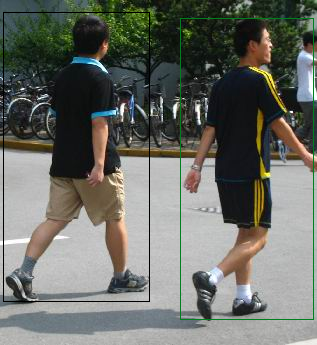

In [40]:
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes

pred_boxes = pred["boxes"]
pred_labels = [f"pedestrian: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]

bbox_image = draw_bounding_boxes(image=X, boxes=pred_boxes) # tensor로 반환

t = v2.ToPILImage() # tensor 데이터를 PILImage로 변환
t(bbox_image)